In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/Phishing_Email.csv')

In [ ]:
blanks = []

for i, row in df.iterrows():
    if isinstance(row["Email Text"], str) and row["Email Text"].isspace():
        blanks.append(i)

print(len(blanks), "   |    ", 'blanks: ', blanks)

df.drop(blanks, inplace=True)



3    |     blanks:  [9605, 13593, 16281]


In [ ]:
# Import the 'stopwords' corpus from the nltk library
# Stop words are commonly used words that are often removed from text during processing to enhance algorithm performance
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Import the 'WordNetLemmatizer' from the nltk library
# Lemmatization is the process of reducing a word to its base or root form (lemma)
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Get the list of English stop words
sw = stopwords.words('english')

# Create an instance of WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def preprocess_text(messy_string):
    # Ensure the input is a string, otherwise handle it gracefully
    if not isinstance(messy_string, str):
        return ''  # Return an empty string or handle it according to your needs

    # Split the string into words, lemmatize each word, remove stop words, and join the words back into a string
    cleaned = ' '.join([lemmatizer.lemmatize(word) for word in messy_string.split() if word not in sw])

    return cleaned



In [ ]:
# Apply the preprocessing function to the 'Email Text' column
df['email'] = df['Email Text'].apply(preprocess_text)

In [ ]:
# Import necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Define the pipeline with a more descriptive name
text_processing_pipeline = Pipeline([
    ('Vectorize', CountVectorizer()),
    ('TF-IDF', TfidfTransformer())
])

In [ ]:
text_processing_pipeline

Pipeline(steps=[('Vectorize', CountVectorizer()),
                ('TF-IDF', TfidfTransformer())])

In [ ]:
# Import 'train_test_split' from sklearn's model_selection module
# This is used to split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# Split 'df["email"]' and 'df["label"]' into training and testing sets
# 'test_size=0.2' means that 20% of the data will be used for testing, and the rest for training
# 'random_state=42' sets the seed for the random number generator used for the split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df["email"], df["Email Type"], test_size=0.2, random_state=42)

In [ ]:
# Fit the text processing pipeline to the training data and transform the training data
# 'fit_transform()' learns the parameters from the data and then transforms the data according to these parameters
X_train = text_processing_pipeline.fit_transform(X_train)

# Transform the testing data using the already fitted pipeline
# 'transform()' uses the parameters learned from 'fit_transform()' to transform the data
X_test = text_processing_pipeline.transform(X_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report , confusion_matrix

Classification report for SVC: 
                precision    recall  f1-score   support

Phishing Email       0.96      0.99      0.98      1498
    Safe Email       0.99      0.97      0.98      2232

      accuracy                           0.98      3730
     macro avg       0.98      0.98      0.98      3730
  weighted avg       0.98      0.98      0.98      3730



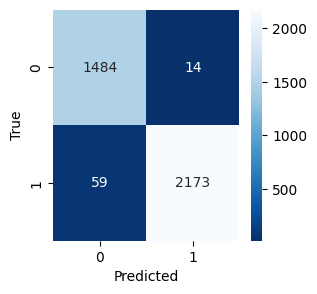

--------------------------------------------
Classification report for RandomForest: 
                precision    recall  f1-score   support

Phishing Email       0.95      0.97      0.96      1498
    Safe Email       0.98      0.97      0.97      2232

      accuracy                           0.97      3730
     macro avg       0.96      0.97      0.97      3730
  weighted avg       0.97      0.97      0.97      3730



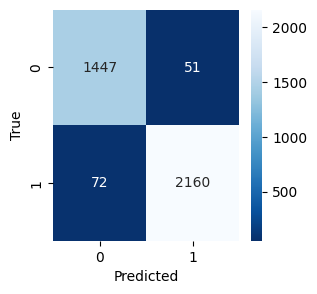

--------------------------------------------
Classification report for LogisticRegression: 
                precision    recall  f1-score   support

Phishing Email       0.96      0.98      0.97      1498
    Safe Email       0.99      0.97      0.98      2232

      accuracy                           0.98      3730
     macro avg       0.97      0.98      0.98      3730
  weighted avg       0.98      0.98      0.98      3730



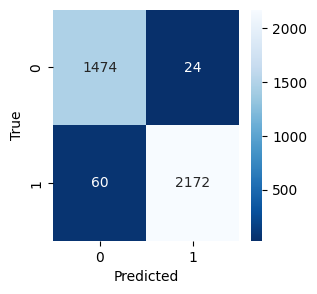

--------------------------------------------
Classification report for MultinomialNB: 
                precision    recall  f1-score   support

Phishing Email       0.97      0.84      0.90      1498
    Safe Email       0.90      0.98      0.94      2232

      accuracy                           0.93      3730
     macro avg       0.94      0.91      0.92      3730
  weighted avg       0.93      0.93      0.92      3730



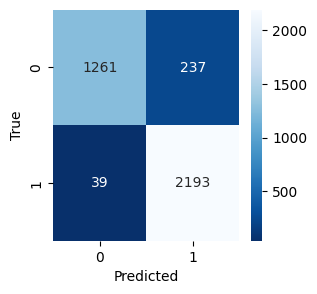

--------------------------------------------


In [ ]:
# Define a dictionary of classifiers for easier referencing and potential scalability
classifiers = {
    "SVC": SVC(kernel='linear'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
    "MultinomialNB": MultinomialNB()
}

# Iterate over each classifier and print report
for classifier_name, classifier_obj in classifiers.items():
    # Fit the model
    classifier_obj.fit(X_train, y_train)

    # Make predictions
    y_pred = classifier_obj.predict(X_test)

    # Generate classification report
    report = classification_report(y_test, y_pred)

    # Print the classification report
    print(f'Classification report for {classifier_name}: ')
    print(report)
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualize the confusion matrix using matplotlib and seaborn
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap = 'Blues_r')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("--------------------------------------------")

In [ ]:
# Test the model with a custom email

#custom_email = "Hi there, How are you doing?"
custom_email = df.iloc[2600]['email']


custom_email = text_processing_pipeline.transform([preprocess_text(custom_email)])

print(classifiers["SVC"].predict(custom_email))

['Safe Email']


In [ ]:
vectorizer = text_processing_pipeline.named_steps['Vectorize']
feature_names = vectorizer.get_feature_names_out()
print("Total Features:", len(feature_names))


Total Features: 147579


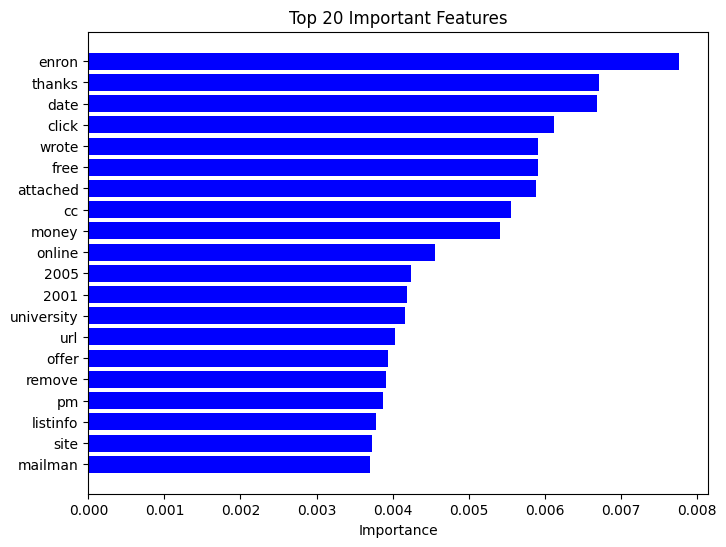

In [ ]:
def plot_feature_importance(model, feature_names, top_n=20):
    if hasattr(model, "coef_"):  # SVC, Logistic Regression
        importance = np.abs(model.coef_).flatten()
    elif hasattr(model, "feature_importances_"):  # Random Forest
        importance = model.feature_importances_
    else:
        print("Feature importance not available for this model")
        return

    sorted_idx = np.argsort(importance)[-top_n:]  # Getting the most important features

    plt.figure(figsize=(8, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='blue')
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Important Features")
    plt.show()

# for example Random Forest
plot_feature_importance(classifiers["RandomForest"], feature_names)


In [ ]:
!pip install lime


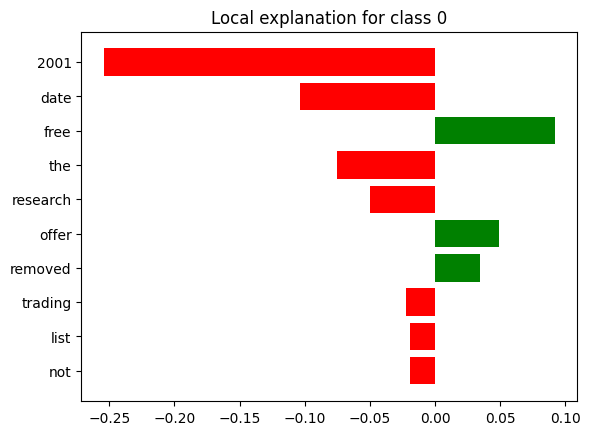

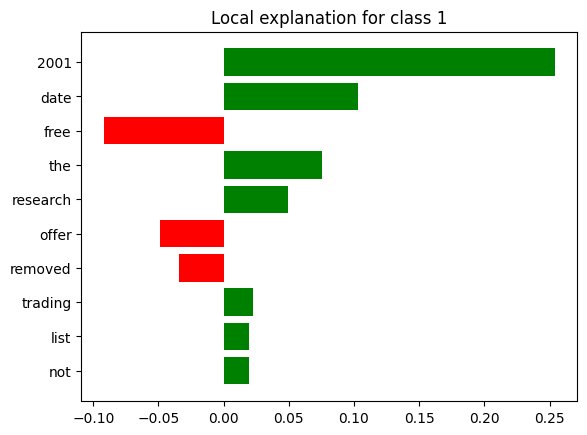

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Training model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Producing description for LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=['Class 0', 'Class 1'],
    mode='classification',
    discretize_continuous=True
)

# Find an example that has a more balanced balance of predictions between the two classes
probabilities = model.predict_proba(X_test)
i = np.argmax(np.abs(probabilities[:, 0] - 0.5))  # Find the closest sample with 50-50 probability

# Get description for selected instance
exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=10, top_labels=2)

# Draw a graph for class 0
fig1 = exp.as_pyplot_figure(label=0)
plt.title("Local explanation for class 0")
plt.show()

# Draw a graph for class 1
fig2 = exp.as_pyplot_figure(label=1)
plt.title("Local explanation for class 1")
plt.show()


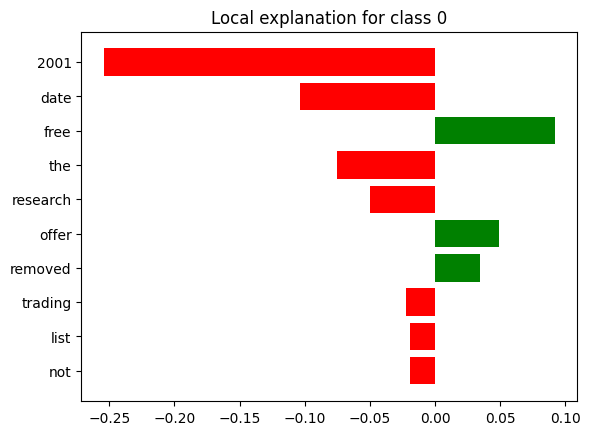

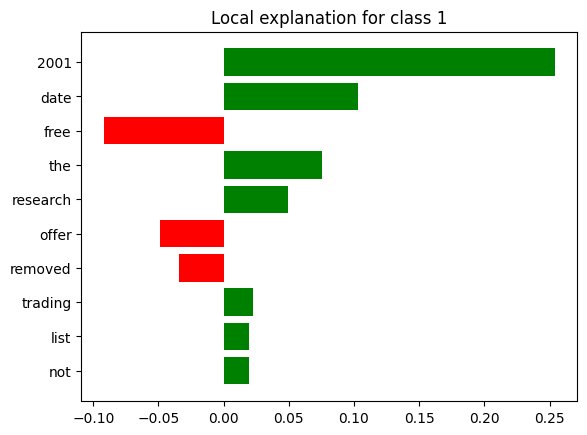

In [ ]:
# Draw a graph for class 0
fig1 = exp.as_pyplot_figure(label=0)
plt.title("Local explanation for class 0")
plt.show()

# Draw a graph for class 1
fig2 = exp.as_pyplot_figure(label=1)
plt.title("Local explanation for class 1")
plt.show()


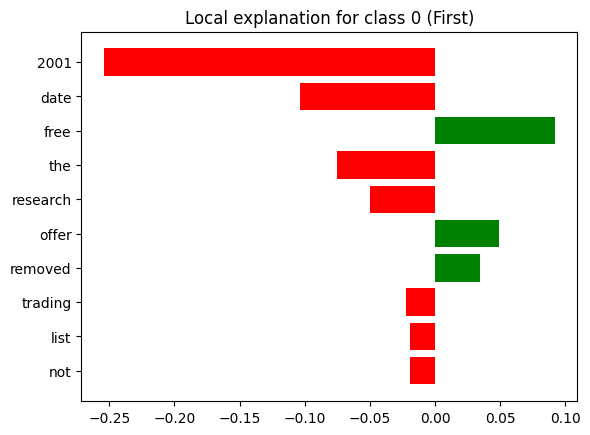

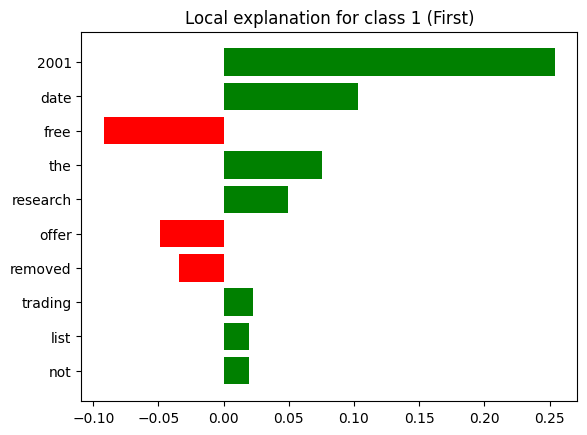

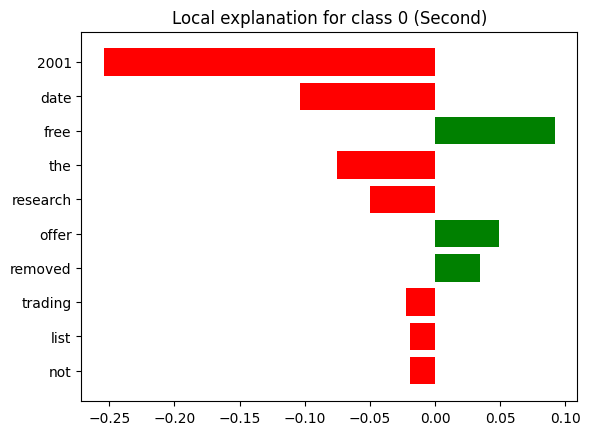

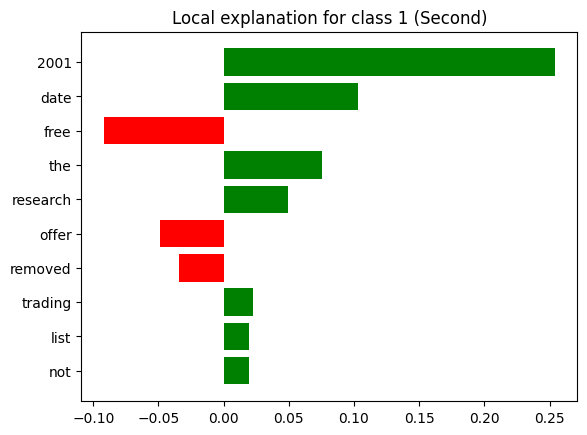

In [ ]:
# Draw four graphs for different classes
fig1 = exp.as_pyplot_figure(label=0)
plt.title("Local explanation for class 0 (First)")
plt.show()

fig2 = exp.as_pyplot_figure(label=1)
plt.title("Local explanation for class 1 (First)")
plt.show()

fig3 = exp.as_pyplot_figure(label=0)
plt.title("Local explanation for class 0 (Second)")
plt.show()

fig4 = exp.as_pyplot_figure(label=1)
plt.title("Local explanation for class 1 (Second)")
plt.show()


In [ ]:
# Convert labels to 0 and 1
y_test_corrected = np.where(y_test == 'Phishing Email', 1, 0)

# Check the number of each class after changing the labels
print(pd.Series(y_test_corrected).value_counts())


0    2232
1    1498
Name: count, dtype: int64


In [ ]:
pca = PCA(n_components=20) # Specify the number of features
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
feature_names = [f'PC{i+1}' for i in range(20)]

In [ ]:
explainer = shap.Explainer(model, X_train_pca)
shap_values = explainer(X_test_pca)

print(f"Shape of SHAP values: {shap_values.shape}")


100%|===================| 7451/7460 [10:26<00:00]       

Shape of SHAP values: (3730, 20, 2)


In [ ]:
shap_values_class_1 = shap_values[:, :, 1]  # Select class 1 values


In [ ]:
shap_values_class_0 = shap_values[:, :, 0]  # Select class 0 values


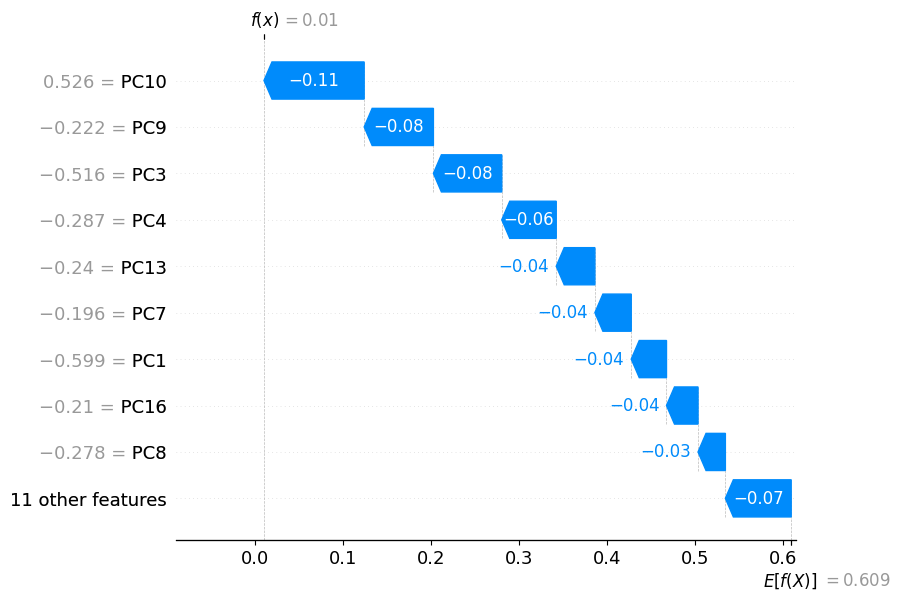

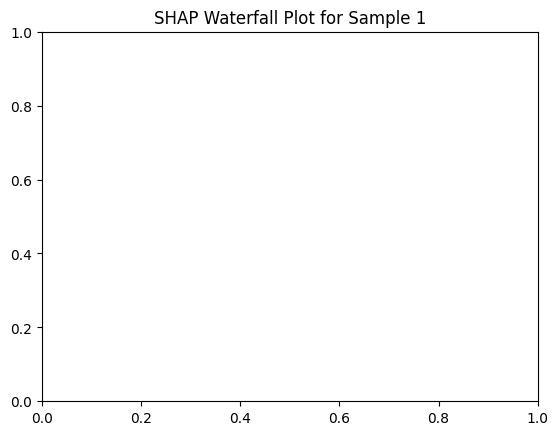

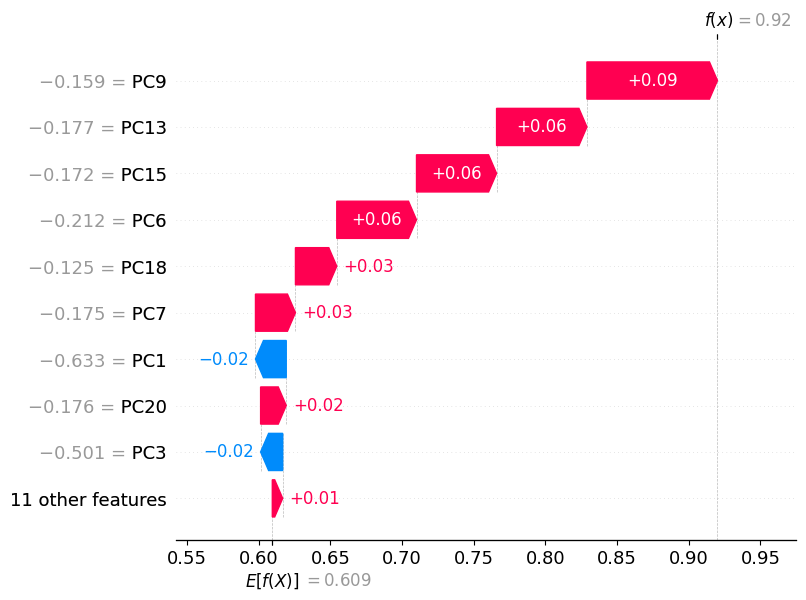

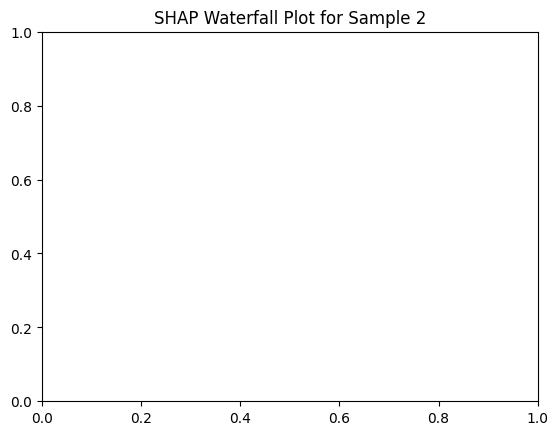

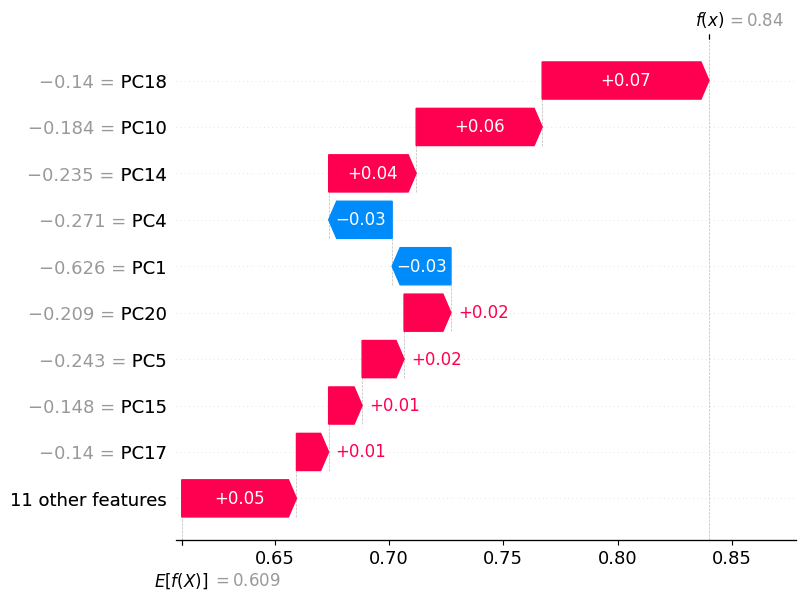

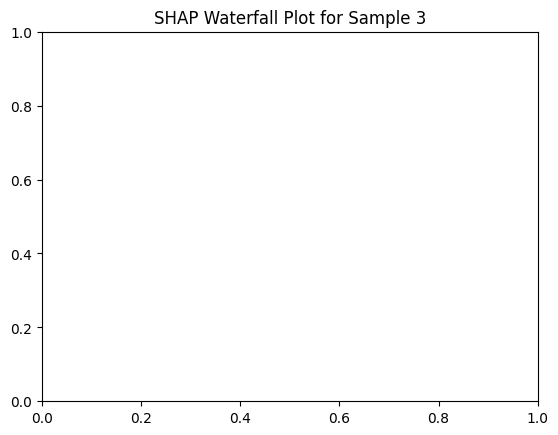

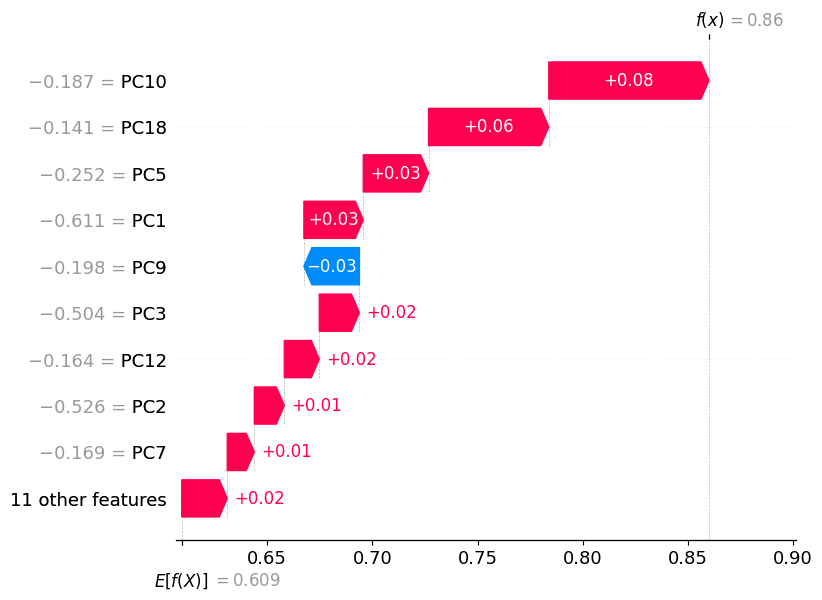

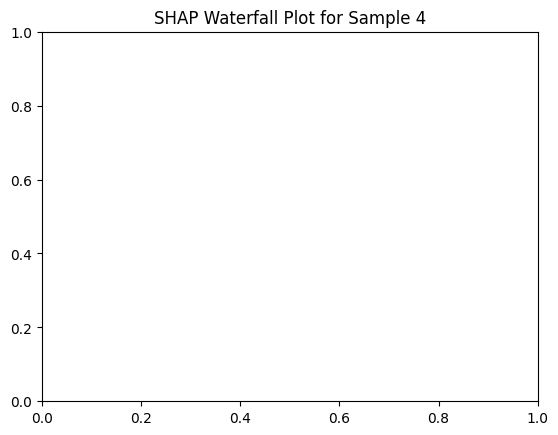

In [ ]:
# Select two examples of phishing emails and two examples of safe emails
phishing_samples = X_test_pca[y_test_series == 1][:2]
safe_samples = X_test_pca[y_test_series == 0][:2]

# Draw a SHAP diagram for these 4 samples
for i, sample in enumerate(np.vstack([phishing_samples, safe_samples])):
    plt.figure()
    shap.waterfall_plot(shap.Explanation(values=shap_values_class_1[i],
                                         base_values=explainer.expected_value[1],
                                         data=sample,
                                         feature_names=feature_names))
    plt.title(f"SHAP Waterfall Plot for Sample {i+1}")
    plt.show()


